# Deep Gaussian process with two output heads

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from src.gp.acdeepsigma import ActorCriticDGP

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "")

In [14]:

    # Generate synthetic data
    def generate_data(n=100):
        x = torch.linspace(-5, 5, n).unsqueeze(-1)
        y_policy = torch.sin(x) + 0.3 * torch.randn(n, 1)  # Policy target
        y_value = 0.5 * torch.cos(x) + 0.1 * torch.randn(n, 1)  # Value target
        return x.to(device), (y_policy.to(device), y_value.to(device))


In [15]:
# Initialize model
model = ActorCriticDGP(
    input_dim=1,
    action_dim=1,
    hidden_layers_config=[{"output_dims": 4, "mean_type": "linear"}],
    policy_hidden_config=[{"output_dims": None, "mean_type": "constant"}],
    value_hidden_config=[{"output_dims": None, "mean_type": "constant"}],
    num_inducing_points=128,
    Q=8,
).to(device)

In [16]:
# Generate data
X, (y_policy, y_value) = generate_data(100)
print(X.shape)
print(y_policy.shape)
print(y_value.shape)

torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])


In [17]:
from gpytorch.mlls import DeepPredictiveLogLikelihood

adam = torch.optim.Adam([{'params': model.parameters()}], lr=0.1, betas=(0.9, 0.999))

# portion of the loss.
objective = DeepPredictiveLogLikelihood(model.likelihood, model, num_data=100)
num_epochs = 30

In [18]:
losses = []
for idx in range(num_epochs):
    # No minibatching just give the data
    adam.zero_grad()
    out1, out2 = model(X)
    loss1 = -objective(out1, y_policy.squeeze(-1))
    # torch.nn.MSELoss()(model.likelihood(out2).rsample().mean(0), y_value.squeeze(-1))   #
    loss2 = -objective(out2, y_value.squeeze(-1))
    loss = loss1 + loss2
    loss.backward()
    losses.append(loss.item())
    print(loss.item())
    adam.step()

2.4473824501037598
2.5014896392822266
2.3403196334838867
2.2410929203033447
2.2042393684387207
2.108288526535034
1.9631917476654053
1.830895185470581
1.730278491973877
1.6352088451385498
1.5356712341308594
1.406941533088684
1.2914454936981201
1.2082606554031372
1.1358642578125
1.0587947368621826
0.9692249298095703
0.8976532220840454
0.8329155445098877
0.7598876953125
0.7140247821807861
0.6405022144317627
0.5689229965209961
0.5204529762268066
0.44424968957901
0.40756112337112427
0.3483811020851135
0.30337274074554443
0.25153106451034546
0.19452407956123352


In [19]:
# Visualization
def plot_results(model, X, y_policy, y_value):
        # Generate test points
        x_test = torch.linspace(-8, 8, 100).unsqueeze(-1).to(device)

        with torch.no_grad():
            policy_dist, value_dist = model.posterior(x_test)

        # Convert to numpy
        x_plot = x_test.cpu().cpu().numpy().squeeze()

        fig, ax = plt.subplots(2, 2, figsize=(12, 8))

        # Policy predictions
        ax[0, 0].plot(x_plot, policy_dist.mean.mean(dim=0).cpu().numpy(), 'b', label='f1 prediction')
        ax[0, 0].fill_between(x_plot,
                              policy_dist.mean.mean(dim=0).cpu().numpy() - 2 * np.sqrt(
                                  policy_dist.variance.mean(dim=0).cpu().numpy()),
                              policy_dist.mean.mean(dim=0).cpu().numpy() + 2 * np.sqrt(
                                  policy_dist.variance.mean(dim=0).cpu().numpy()),
                              alpha=0.2, color='b')
        ax[0, 0].scatter(X.cpu().numpy(), y_policy.cpu().numpy(), c='r', s=10, label='f1 targets')
        ax[0, 0].set_title('Target 1 Predictions')
        ax[0, 0].legend()

        # Value predictions
        ax[0, 1].plot(x_plot, value_dist.mean.mean(dim=0).cpu().numpy(), 'g', label='f2 prediction')
        ax[0, 1].fill_between(x_plot,
                              value_dist.mean.mean(dim=0).cpu().numpy() - 2 * np.sqrt(
                                  value_dist.variance.mean(dim=0).cpu().numpy()),
                              value_dist.mean.mean(dim=0).cpu().numpy() + 2 * np.sqrt(
                                  value_dist.variance.mean(dim=0).cpu().numpy()),
                              alpha=0.2, color='g')
        ax[0, 1].scatter(X.cpu().numpy(), y_value.cpu().numpy(), c='m', s=10, label='f2 targets')
        ax[0, 1].set_title('Target 2 Predictions')
        ax[0, 1].legend()

        # Training curve
        ax[1, 0].plot(losses)
        ax[1, 0].set_title('Training Loss')
        ax[1, 0].set_xlabel('Epoch')
        ax[1, 0].set_ylabel('Loss')

        # Ground truth comparison
        ax[1, 1].plot(x_plot, torch.sin(torch.tensor(x_plot)).cpu().numpy(), 'r--', label='True f1')
        ax[1, 1].plot(x_plot, 0.5 * torch.cos(torch.tensor(x_plot)).cpu().numpy(), 'b--', label='True f2')
        ax[1, 1].set_title('Ground Truth Functions')
        ax[1, 1].legend()

        plt.tight_layout()
        plt.show()
        plt.savefig("plot!")
        plt.savefig("plot!.svg")

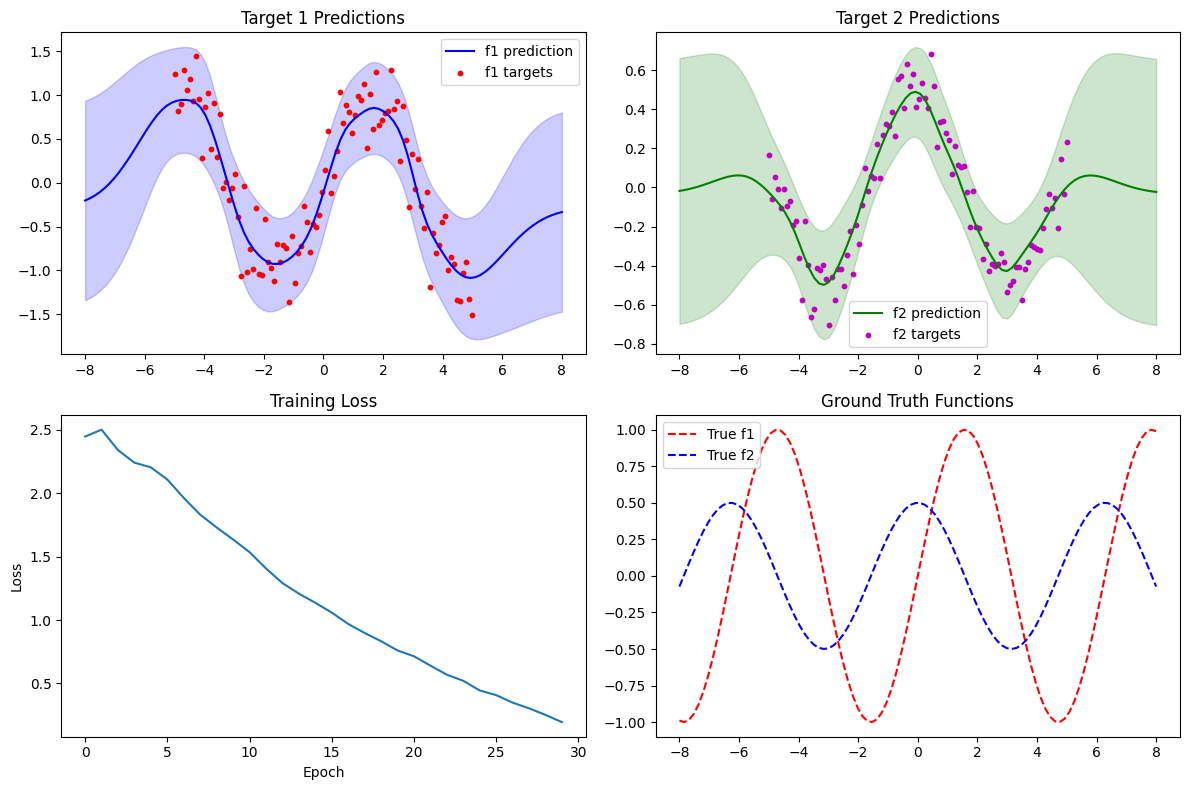

<Figure size 640x480 with 0 Axes>

In [20]:
plot_results(model, X, y_policy, y_value)